# Assist Analysis

In [226]:
!pip install -q dmba
!pip install fa2
!pip install bezier
%matplotlib inline

from pathlib import Path
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
import xlrd,xlwt
import bezier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from dmba import classificationSummary
from scipy.stats import itemfreq
import matplotlib.pyplot as plt
import networkx as nx
from fa2 import ForceAtlas2

In [224]:
import networkx as nx
import numpy as np

def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity='random'):
    # Get nodes into np array
    edges = np.array(G.edges())
    l = edges.shape[0]

    if polarity == 'random':
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l)==0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(np.mod(np.vectorize(hash)(edges[:,0])+np.vectorize(hash)(edges[:,1]),2)==0,-1,1)
    
    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse = True)
    coords = np.array([pos[x] for x in u])[inv].reshape([edges.shape[0], 2, edges.shape[1]])
    coords_node1 = coords[:,0,:]
    coords_node2 = coords[:,1,:]
    
    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:,0] > coords_node2[:,0]
    coords_node1[should_swap], coords_node2[should_swap] = coords_node2[should_swap], coords_node1[should_swap]
    
    # Distance for control points
    dist = dist_ratio * np.sqrt(np.sum((coords_node1-coords_node2)**2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])
    m2 = -1/m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist/np.sqrt(1+m1**2)
    v1 = np.array([np.ones(l),m1])
    coords_node1_displace = coords_node1 + (v1*t1).T
    coords_node2_displace = coords_node2 - (v1*t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist/np.sqrt(1+m2**2)
    v2 = np.array([np.ones(len(edges)),m2])
    coords_node1_ctrl = coords_node1_displace + (rnd*v2*t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd*v2*t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array([coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2])

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:,i,:].T
        curveplots.append(bezier.Curve(nodes, degree=3).evaluate_multi(np.linspace(0,1,bezier_precision)).T)
      
    # Return an array of these curves
    curves = np.array(curveplots)
    return curves

In [145]:
Assist_df = pd.read_csv('Assist.csv')
CurryShots_df=pd.read_csv('CurryShots.csv')
var1 = ['Shooter','Assister']
var2 = ['ShotDist']



assistTable = Assist_df[var1]

assistTable=np.array(assistTable,dtype=object)
#itemfreq(assistTable)
#print(len(assistTable[1:4]))
AssistPairs,counts=np.unique(assistTable.astype("<U22"),axis=0,return_counts=True)

# for i in range(0,len(counts)):
#     print(AssistPairs[i,0],AssistPairs[i,1],counts[i])
counts=counts.T
print(type(counts[1]))
#counts=list(map(int,counts))
print(counts)
astStats=np.insert(AssistPairs,2,values=counts,axis=1)
#print(astStats)
for i in range(len(astStats)-1):
    for j in range(i+1,len(astStats)):
        if int(astStats[i,2])<int(astStats[j,2]):
            #astStats[i],astStats[j]=astStats[j],astStats[i]
            astStats[[i, j], :] = astStats[[j, i], :]

print(astStats)
def save(data, path):
    f = xlwt.Workbook()  # 创建工作簿
    sheet1 = f.add_sheet(u'sheet1', cell_overwrite_ok=True)  # 创建sheet
    [h, l] = data.shape  # h为行数，l为列数
    for i in range(h):
        for j in range(l):
            sheet1.write(i, j, data[i, j])
    f.save(path)

save(astStats,'/Users/mckay1999/JupyterFiles/NBA/assistRank.xls')


curryShotsTable = CurryShots_df[var2]
curryShotsTable=np.array(curryShotsTable)
print(curryShotsTable[2])
# y = example_df[outcome]
# p=X.loc[3:6]






<class 'numpy.int64'>
[ 40  24  12   2   1  23   1   8   7   2  61  17   4   1   1   1   1  35
  17   7   1   3  38   1  36   3   8  86  16  25   2   1   1   1   3  31
  20  11  20  14   5   5  13  18   1  17   3   2  34  34   7   4  27   7
   6   8  10  16  12   2   7   3   1   6   1   5   2   6   2   7   7  11
   1  17  53  12  23   1  18   3  13  52   4  55   1 111  21  11   1   2
   2  28   8 132  18  33   5   2   1   3   1   5   1   6   4   6   9   2
   2  63 152  50   8   1   4  96   3   9  13 150  26  36   2   3   5   3
   2   1   3  13   4   2   7   2   2  13   8   7   1  10   6   8   1  22
   7   7  52   1 154   9   9   2   4  81   2  24   7  15  21  28  15   1
  26  17   4   2  12   1   9   3   2  15   1   5  28   1   2  22   1  30
   4   2  61   2]
[['S. Curry - GSW' 'D. Green - GSW' '154']
 ['K. Thompson - GSW' 'D. Green - GSW' '152']
 ['K. Thompson - GSW' 'S. Curry - GSW' '150']
 ['K. Durant - GSW' 'S. Curry - GSW' '132']
 ['K. Durant - GSW' 'D. Green - GSW' '111']
 ['K. T

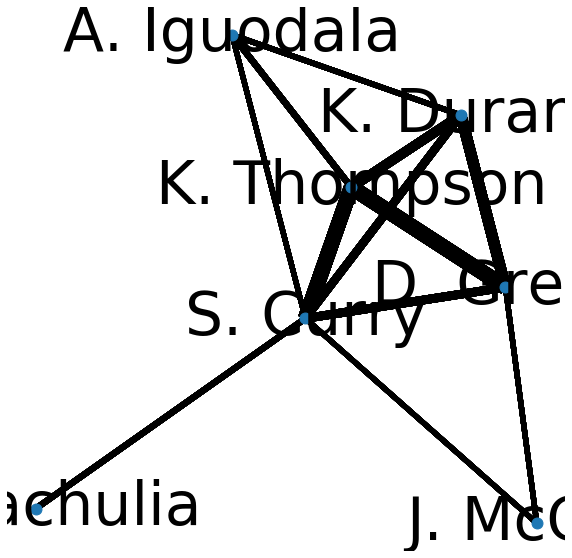

In [221]:
G = nx.Graph()
astStats=astStats[:15,:]
for i in range(len(astStats)):
    G.add_edge(astStats[i,0][0:-6], astStats[i,1][0:-6], weight=int(astStats[i,2])/10)
    #nx.draw_networkx_edges(G, pos, edgelist=elarge,width=6)
#G.edges(1)
# G.add_edge('a', 'b', weight=0.6)
# G.add_edge('a', 'c', weight=0.2)
# G.add_edge('c', 'd', weight=0.1)
# G.add_edge('c', 'e', weight=0.7)
# G.add_edge('c', 'f', weight=0.9)
# G.add_edge('a', 'd', weight=0.3)

# elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
# esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(G)  # positions for all nodes
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
#edgewidth = edgewidth/10
for i in range(len(astStats)):

    nx.draw_networkx_edges(G, pos, width=edgewidth)
# # nodes
nx.draw_networkx_nodes(G, pos, node_size=120)

# # edges
# nx.draw_networkx_edges(G, pos,
#                         width=[1,2])
# nx.draw_networkx_edges(G, pos, edgelist=esmall,
#                        width=6, alpha=0.5, edge_color='b', style='dashed')

# # labels
nx.draw_networkx_labels(G, pos, font_size=60, font_family='sans-serif')

plt.axis('off')
plt.rcParams['figure.figsize']=(10.0,10.0)
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 48067.29it/s]


BarnesHut Approximation  took  0.00  seconds
Repulsion forces  took  0.00  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds
[('A. Iguodala', 'S. Curry'), ('A. Iguodala', 'K. Durant'), ('A. Iguodala', 'K. Thompson'), ('S. Curry', 'D. Green'), ('S. Curry', 'J. McGee'), ('S. Curry', 'K. Durant'), ('S. Curry', 'K. Thompson'), ('S. Curry', 'Z. Pachulia'), ('D. Green', 'J. McGee'), ('D. Green', 'K. Durant'), ('D. Green', 'K. Thompson'), ('K. Durant', 'K. Thompson')]
[ 52  55  63 154  52  81 150  61  53 111 152  96]


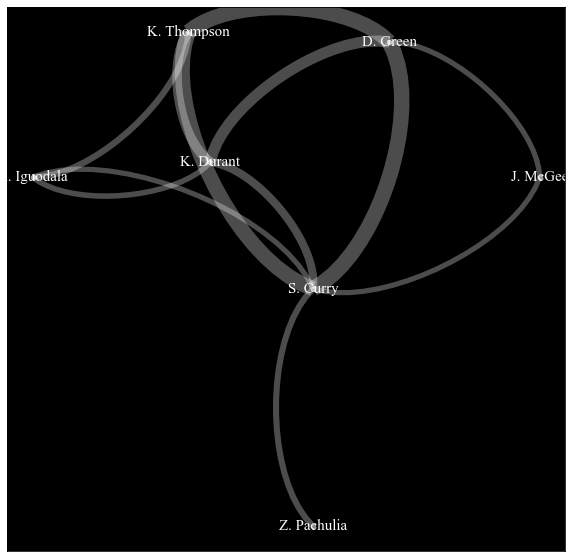

In [265]:
got_data = 'assistForGraph.csv'
dfg = pd.DataFrame()
for i in range(7):
    df_current = pd.read_csv(got_data.format(i+1),
                           names=['Shooter','Assister','weight'],
                           skiprows=1)
    dfg = pd.concat([dfg, df_current])
    dfg=dfg[:15]


# Group by the edges so they are not duplicated
dfgt = dfg.groupby(['Shooter','Assister'], as_index=False).agg({'weight':'sum'})

# # Remove some outliers
# outliers = ['BLACK_JACK','KEGS','MULLY']
# dfgt = dfgt[~dfgt.source.isin(outliers)&~dfgt.target.isin(outliers)]

# Load graph from pandas and calculate positions
G = nx.from_pandas_edgelist(dfgt, source='Shooter', target='Assister', edge_attr='weight')
#G=G[:15]
forceatlas2 = ForceAtlas2(edgeWeightInfluence=0)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

# Get curves
print(G.edges())
curves = curved_edges(G, positions)

# Make a matplotlib LineCollection - styled as you wish
weights = np.array([x[2]['weight'] for x in G.edges(data=True)])
print(weights)
widths =  0.1*weights
lc = LineCollection(curves, color='w', alpha=0.3, linewidths=widths)

# Plot
plt.figure(figsize=(10,10))
plt.gca().set_facecolor('k')
nx.draw_networkx_nodes(G, positions, node_size=20, node_color='w', alpha=0.5)
nx.draw_networkx_labels(G, positions, font_size=15, font_color='white',font_family='Times New Roman')
plt.gca().add_collection(lc)
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
plt.show()